# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


All data get stored in a python object InputData.  This object can be easily stored in a Python pickle. However, these files have the limitation that all dependecies must have the same versions as those when the pickle were created. For these reason to have more stable tutorials we will generate the InputData from raw data---i.e. csv files exported from Geomodeller.

These csv files can be found in the input_data folder in the root folder of GemPy. These tables contains uniquely the XYZ (and poles, azimuth and polarity in the foliation case) as well as their respective formation name (but not necessary the formation order).


In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 60,60,60],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

../../gempy/data_management.py:61: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ]) 

#geo_data =gp.select_series(geo_data, ['Rest'])

## The ins and outs of Input data objects

As we have seen objects DataManagement.InputData (usually called geo_data in the tutorials) aim to have all the original geological properties, measurements and geological relations stored. 

Once we have the data ready to generate a model, we will need to create the next object type towards the final geological model:

In [8]:
import theano.tensor as T
import theano
interp_data = gp.InterpolatorData(geo_data, u_grade=[1, 1],
                                  output='geology', dtype='float64',
                                   verbose=['scalar_field_iter', 'block_series'],
                                  compile_theano=True)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [9]:
sol = gp.compute_model(interp_data)

scalar_field_iter __str__ = [ 40.0782547   39.44039536]
middle point __str__ = [ 1.  1.  1. ...,  1.  1.  1.]
The chunk of block model of a specific series __str__ = [ 1.  1.  1. ...,  1.  1.  1.]
scalar_field_iter __str__ = [ 40.0782547   39.44039536]
middle point __str__ = [ 1.  1.  1. ...,  1.  1.  1.]
The chunk of block model of a specific series __str__ = [ 1.  1.  1. ...,  1.  1.  1.]
scalar_field_iter __str__ = [ 30.62537956  30.48460007  30.46243858  30.34952164  30.26959038]
middle point __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
middle point __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
middle point __str__ = [  2.84846453e-29   2.11047087e-28   1.58469743e-27 ...,   4.23637862e-18
   4.23637862e-18   4.23637862e-18]
middle point __str__ = [  6.47833263e-12   4.79989520e-11   3.60411589e-10 ...,   4.90702718e-01
   4.90702718e-01   4.90702718e-01]
The chunk of block model of a specific series __str__ = [  6.47833263e-12   4.79989520e-11   3.60411589e-10 ...,   4.90702718e-01
   4.90

<IPython.core.display.Javascript object>


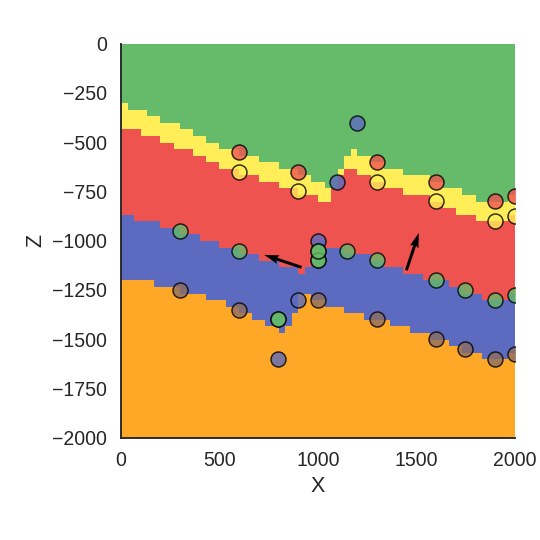

[[  1.05719618e-26   1.72435873e-26   3.00671253e-26 ...,   5.98632264e-17
    2.86966226e-17   1.17870483e-17]
 [  5.15840306e-26   8.31003827e-26   1.43250854e-25 ...,   1.03842036e-15
    5.05923515e-16   2.08203240e-16]
 [  2.63987717e-25   4.20036631e-25   7.14468216e-25 ...,   1.90556003e-14
    9.45373896e-15   3.89421915e-15]
 ..., 
 [  4.00000000e+00   4.00000000e+00   4.00000000e+00 ...,   4.00000000e+00
    4.00000000e+00   4.00000000e+00]
 [  4.00000000e+00   4.00000000e+00   4.00000000e+00 ...,   4.00000000e+00
    4.00000000e+00   4.00000000e+00]
 [  4.00000000e+00   4.00000000e+00   4.00000000e+00 ...,   4.00000000e+00
    4.00000000e+00   4.00000000e+00]] <class 'numpy.ndarray'>


In [10]:
%matplotlib notebook
gp.plot_section(geo_data,sol[0][0].astype(float), 30, plot_data = True)

In [7]:
gssg
interp_data.interpolator.tg.n_formation_float.get_value()

NameError: name 'gssg' is not defined

In [ ]:
geo_data.interfaces

In [ ]:
input_data_T = the.input_parameters_list()
input_data_T

In [ ]:
th_fn = theano.function(input_data_T,
                         the.compute_grad(1),
                                    on_unused_input='ignore',
                                    allow_input_downcast=False,
                                    profile=False)

In [ ]:
i = interp_data.get_input_data()

In [ ]:
interp_data.interpolator.pandas_rest_layer_points.head()

In [ ]:
th_fn(*i)

In [ ]:
lith_block, fault_block = gp.compute_model(interp_data)

In [ ]:
lith_block[0][(lith_block[0] > 1 ) * (lith_block[0] < 2)]

In [ ]:
lith_block[0] < 2

In [ ]:
np.unique(lith_block[0])

In [ ]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 10, plot_data=True)

In [ ]:
the.input_parameters_list()

In [ ]:
# cov_jac = T.jacobian(T.flatten(the.block_series()),
#                      the.input_parameters_list()[-1])

In [ ]:
gp.set_geophysics_obj(interp_data,  [800,1200,800,1200,-800, -1200],
                                             [5,5])

In [ ]:
a,b = gp.precomputations_gravity(interp_data, 24, [2.92, 3.1, 2.92, 2.61, 2.61])

In [ ]:
grad = the.compute_grad(0)

In [ ]:
grad = the.compute_forward_gravity(1)

In [ ]:
#from theano.compile.nanguardmode import NanGuardMode
f =theano.function(the.input_parameters_list(), grad,
              #  mode=NanGuardMode(nan_is_error=True),
                on_unused_input='ignore',
                allow_input_downcast=False,
                profile=False)

In [ ]:
import pymc3 as pm

In [ ]:
a = pm.Model()

In [ ]:
a.

In [ ]:
from theano import function, OpFromGraph, tensor, grad
x, y, z = tensor.scalars('xyz')
e = x + y * z
def rescale_dy(inps, grads):
    x, y, z = inps
    g, = grads
    return z*2
op = OpFromGraph(
    [x, y, z], [e], grad_overrides=['default', rescale_dy, 'default'])
e2 = op(x, y, z)
dx, dy, dz = grad(e2, [x, y, z])
fn = function([x, y, z], [dx, dy, dz])
# the gradient wrt y is now doubled
fn(2., 3., 4.) # [1., 8., 3.]